# Visualize Geo Variables and Examine Normalization

This notebook loads data based on a config file and allows you to:
- Load data from train/validate/test splits
- Print available channels and normalization variables
- Visualize raw and normalized data
- Examine normalization statistics

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '/home/deepakns/Work/MoK_date_predict/src')

import torch
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path

from data_pipeline.loaders.utils import load_config_and_create_dataloaders
from data_pipeline.preprocessing.normstats import load_normalization_stats
from data_pipeline.preprocessing.transformers import NormalizeWithPrecomputedStats

# Set matplotlib style
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Configuration

In [6]:
# Specify your config file path here
CONFIG_PATH = "/home/deepakns/Work/MoK_date_predict/config/model_config_with_wandb.yml"

# Choose which split to examine: 'train', 'val', or 'test'
SPLIT = 'val'

# Optional: specify a particular year (set to None to use the first year in the split)
YEAR = 2001  # e.g., 1950, or None

## 3. Load Config and Display Settings

In [4]:
# Load and display config
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

print("="*80)
print("CONFIG SETTINGS")
print("="*80)
print(f"\nData Configuration:")
print(f"  Data directory: {config['data']['data_dir']}")
print(f"  Target file: {config['data']['target_file']}")
print(f"\nYears:")
print(f"  Train years: {config['data']['train_years']}")
print(f"  Val years: {config['data']['val_years']}")
print(f"  Test years: {config['data']['test_years']}")
print(f"\nVariables:")
print(f"  Surface variables: {config['data']['input_geo_var_surf']}")
print(f"  Pressure variables: {config['data']['input_geo_var_press']}")
print(f"\nTime/Space Configuration:")
print(f"  Time steps (months): {config['data']['time_steps']}")
print(f"  Pressure levels: {config['data']['pressure_levels']}")
print(f"\nStatic Channels:")
print(f"  Include latitude: {config['data'].get('include_lat', False)}")
print(f"  Include longitude: {config['data'].get('include_lon', False)}")
print(f"  Include land-sea mask: {config['data'].get('include_landsea', False)}")
print(f"\nNormalization:")
print(f"  Strategy: {config['data'].get('normalize_strategy', 0)}")
print(f"  (0=none, 1=use training stats)")
print("="*80)

CONFIG SETTINGS

Data Configuration:
  Data directory: /gdata2/ERA5/monthly
  Target file: /home/deepakns/Work/data/MoKDates.csv

Years:
  Train years: ['1951:2000']
  Val years: ['2001:2010']
  Test years: ['2011:2024']

Variables:
  Surface variables: ['sst', 'ttr', 'tcc', 'msl']
  Pressure variables: ['u', 'v']

Time/Space Configuration:
  Time steps (months): [2]
  Pressure levels: [0, 1]

Static Channels:
  Include latitude: False
  Include longitude: False
  Include land-sea mask: False

Normalization:
  Strategy: 1
  (0=none, 1=use training stats)


## 4. Load Data

In [7]:
# Load data using the config
print("Loading data...")
(train_loader, train_ds), (val_loader, val_ds), (test_loader, test_ds) = \
    load_config_and_create_dataloaders(CONFIG_PATH, return_datasets=True)

# Select the appropriate split
if SPLIT == 'train':
    loader = train_loader
    dataset = train_ds
elif SPLIT == 'val':
    loader = val_loader
    dataset = val_ds
elif SPLIT == 'test':
    loader = test_loader
    dataset = test_ds
else:
    raise ValueError(f"Invalid SPLIT: {SPLIT}. Choose 'train', 'val', or 'test'")

print(f"\nLoaded {SPLIT} split with {len(dataset)} samples")

# Get available years in this split
available_years = sorted(list(set([dataset.get_metadata(i)['year'] for i in range(len(dataset))])))
print(f"Available years in {SPLIT} split: {available_years}")

Loading data...
  Using regression target: DateRelJun01
  Using regression target: DateRelJun01
  Using regression target: DateRelJun01

Loaded val split with 10 samples
Available years in val split: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]


## 5. Print All Available Channels

In [9]:
# Get channel information
channel_info = dataset.get_channel_info()

print("="*80)
print("CHANNEL INFORMATION")
print("="*80)
print(f"\nTotal number of channels: {channel_info['num_channels']}")
print(f"\nTime steps used: {channel_info['time_steps']}")
print(f"Pressure levels used: {channel_info['pressure_levels']}")
print(f"\nAll channels (in order):")
for i, channel_name in enumerate(channel_info['channel_names']):
    print(f"  [{i:2d}] {channel_name}")
print("="*80)

CHANNEL INFORMATION

Total number of channels: 8

Time steps used: [2]
Pressure levels used: [0, 1]

All channels (in order):
  [ 0] sst_t2
  [ 1] ttr_t2
  [ 2] tcc_t2
  [ 3] msl_t2
  [ 4] u1_t2
  [ 5] u2_t2
  [ 6] v1_t2
  [ 7] v2_t2


## 6. Load and Print Normalization Statistics

In [12]:
# Check if normalization stats exist
model_name = config.get('model', {}).get('name', 'MoK_CNN_28p1')

print(f"\nAttempting to load normalization stats for model: {model_name}")

try:
    stats = load_normalization_stats(model_name)
    
    print("="*80)
    print("NORMALIZATION STATISTICS")
    print("="*80)
    print(f"\nModel name: {model_name}")
    print(f"Mean shape: {stats.mean.shape}")
    print(f"Std shape: {stats.std.shape}")
    print(f"Channel names: {stats.channel_names}")
    print(f"Number of channels: {len(stats.channel_names)}")
    print(f"\nStatic channels (NOT normalized):")
    if stats.static_channel_indices:
        for idx in stats.static_channel_indices:
            print(f"  [{idx}] {stats.channel_names[idx]}")
    else:
        print("  None")
    
    print(f"\nNormalizable channels:")
    normalizable = stats.get_normalizable_indices()
    for idx in normalizable:
        print(f"  [{idx}] {stats.channel_names[idx]}")
    
    print(f"\nComputed from {stats.num_samples} training samples")
    #print(f"Training years: {stats.train_years}")
    
    # Display summary statistics for each channel
    print(f"\nSummary statistics per channel:")
    print(f"{'Channel':<15} {'Mean (global)':<15} {'Std (global)':<15} {'Mean (min)':<15} {'Mean (max)':<15}")
    print("-"*75)
    for i, name in enumerate(stats.channel_names):
        mean_global = stats.mean[i].mean().item()
        std_global = stats.std[i].mean().item()
        mean_min = stats.mean[i].min().item()
        mean_max = stats.mean[i].max().item()
        print(f"{name:<15} {mean_global:<15.3f} {std_global:<15.3f} {mean_min:<15.3f} {mean_max:<15.3f}")
    
    print("="*80)
    
    STATS_LOADED = True
    
except FileNotFoundError:
    print(f"\nNormalization stats not found for model '{model_name}'")
    print("Available models with stats:")
    stats_dir = Path("/home/deepakns/Work/MoK_date_predict/src/data_pipeline/preprocessing/normstats/saved_stats")
    if stats_dir.exists():
        for model_dir in stats_dir.iterdir():
            if model_dir.is_dir():
                print(f"  - {model_dir.name}")
    STATS_LOADED = False


Attempting to load normalization stats for model: MoK_CNN_28p1

Loaded normalization statistics for: MoK_CNN_28p1
  Location: /home/deepakns/Work/MoK_date_predict/src/data_pipeline/preprocessing/normstats/saved_stats/MoK_CNN_28p1
  Num samples: 50
  Shape: [8, 481, 1440]
  Channels: 8
NORMALIZATION STATISTICS

Model name: MoK_CNN_28p1
Mean shape: torch.Size([8, 481, 1440])
Std shape: torch.Size([8, 481, 1440])
Channel names: ['sst_t2', 'ttr_t2', 'tcc_t2', 'msl_t2', 'u1_t2', 'u2_t2', 'v1_t2', 'v2_t2']
Number of channels: 8

Static channels (NOT normalized):
  None

Normalizable channels:
  [0] sst_t2
  [1] ttr_t2
  [2] tcc_t2
  [3] msl_t2
  [4] u1_t2
  [5] u2_t2
  [6] v1_t2
  [7] v2_t2

Computed from 50 training samples

Summary statistics per channel:
Channel         Mean (global)   Std (global)    Mean (min)      Mean (max)     
---------------------------------------------------------------------------
sst_t2          214.283         0.673           0.000           305.666        
t

## 7. Select a Sample to Visualize

In [13]:
# Find sample index for the specified year or use first sample
if YEAR is not None:
    sample_idx = None
    for i in range(len(dataset)):
        if dataset.get_metadata(i)['year'] == YEAR:
            sample_idx = i
            break
    if sample_idx is None:
        print(f"Warning: Year {YEAR} not found in {SPLIT} split. Using first sample.")
        sample_idx = 0
else:
    sample_idx = 0

# Load the sample
data, target = dataset[sample_idx]
metadata = dataset.get_metadata(sample_idx)

print(f"\nSelected sample:")
print(f"  Index: {sample_idx}")
print(f"  Year: {metadata['year']}")
print(f"  Data shape: {data.shape}")
print(f"  Target (MoK date): {target}")


Selected sample:
  Index: 0
  Year: 2001
  Data shape: torch.Size([8, 481, 1440])
  Target (MoK date): tensor([-8.])


## 8. Visualization Functions

In [ ]:
def visualize_channel(data, channel_idx, channel_name, title_prefix="", vmin=None, vmax=None, cmap='RdBu_r'):
    """
    Visualize a single channel
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(data[channel_idx], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_title(f"{title_prefix}{channel_name}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig

def visualize_raw_vs_normalized(raw_data, normalized_data, channel_idx, channel_name, rawvmin=None, rawvmax=None, normvmin=None, normvmax=None):
    """
    Compare raw and normalized data side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw data
    im1 = ax1.imshow(raw_data[channel_idx], cmap='viridis', vmin=rawvmin, vmax=rawvmax, aspect='auto')
    ax1.set_title(f'Raw: {channel_name}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Normalized data
    im2 = ax2.imshow(normalized_data[channel_idx], cmap='RdBu_r', vmin=normvmin, vmax=normvmax, aspect='auto')
    ax2.set_title(f'Normalized: {channel_name}')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    return fig

def visualize_normalization_stats(stats, channel_idx, channel_name):
    """
    Visualize the mean and std fields for a channel
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Mean field
    im1 = ax1.imshow(stats.mean[channel_idx], cmap='RdBu_r', aspect='auto')
    ax1.set_title(f'Mean Field: {channel_name}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Std field
    im2 = ax2.imshow(stats.std[channel_idx], cmap='viridis', aspect='auto')
    ax2.set_title(f'Std Field: {channel_name}')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    return fig

def visualize_all_channels_grid(data, channel_names, ncols=4, figsize=(16, 12), vmin=None, vmax=None, cmap='RdBu_r'):
    """
    Visualize all channels in a grid
    """
    n_channels = len(channel_names)
    nrows = (n_channels + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if n_channels > 1 else [axes]
    
    for i, (channel_name) in enumerate(channel_names):
        ax = axes[i]
        im = ax.imshow(data[i], cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(channel_name, fontsize=9)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(n_channels, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    return fig

print("Visualization functions defined.")

Visualization functions defined.


## 9. Ready for Interactive Visualization

The notebook is now ready. Below are example cells you can use to visualize data.

**Available objects:**
- `data`: Raw data tensor (channels, lat, lon)
- `dataset`: Dataset object for the selected split
- `channel_info`: Dictionary with channel names and info
- `stats`: Normalization statistics (if loaded)
- `metadata`: Metadata for the selected sample

**Available functions:**
- `visualize_channel(data, channel_idx, channel_name, ...)`
- `visualize_raw_vs_normalized(raw_data, normalized_data, channel_idx, channel_name)`
- `visualize_normalization_stats(stats, channel_idx, channel_name)`
- `visualize_all_channels_grid(data, channel_names, ...)`

### Example: Visualize a Single Channel (Raw Data)

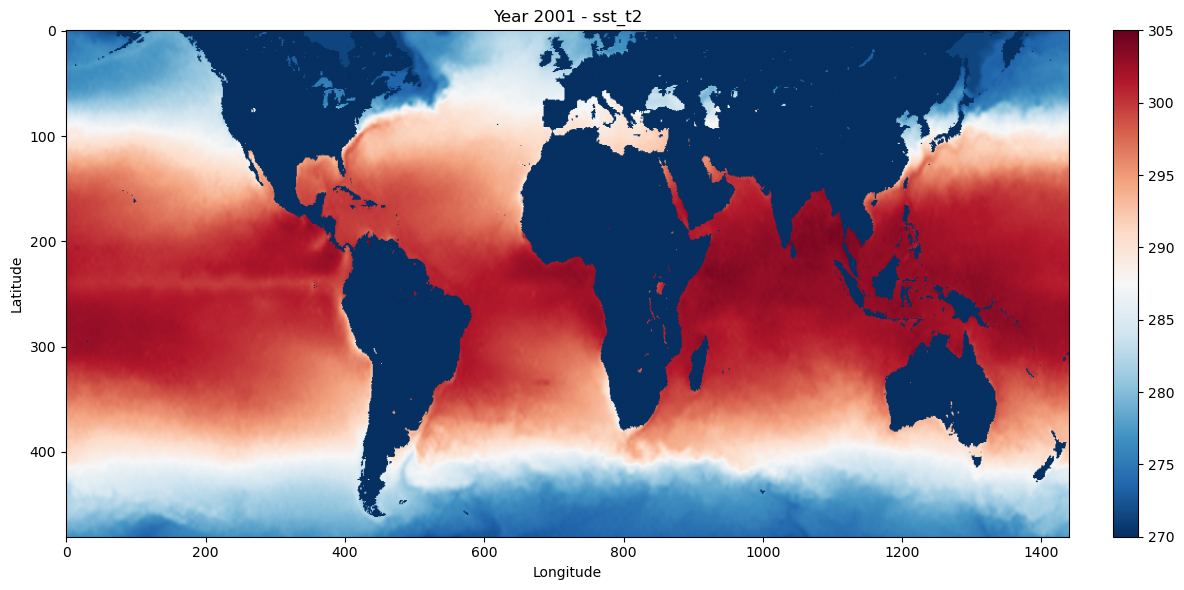

In [18]:
# Example: Visualize SST at time step 2
channel_name = 'sst_t2'  # Change this to any channel name
channel_idx = channel_info['channel_names'].index(channel_name)

visualize_channel(
    data, 
    channel_idx, 
    channel_name, 
    title_prefix=f"Year {metadata['year']} - ",
    vmin = 270,
    vmax = 305
)
plt.show()

### Example: Visualize All Channels (Grid View)

In [ ]:
# Visualize all channels in a grid
visualize_all_channels_grid(
    data, 
    channel_info['channel_names'],
    ncols=4,
    figsize=(16, 12)
)
plt.suptitle(f"All Channels - Year {metadata['year']}", fontsize=14, y=0.995)
plt.show()

### Example: Compare Raw vs Normalized Data

ValueError: 'virdis' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

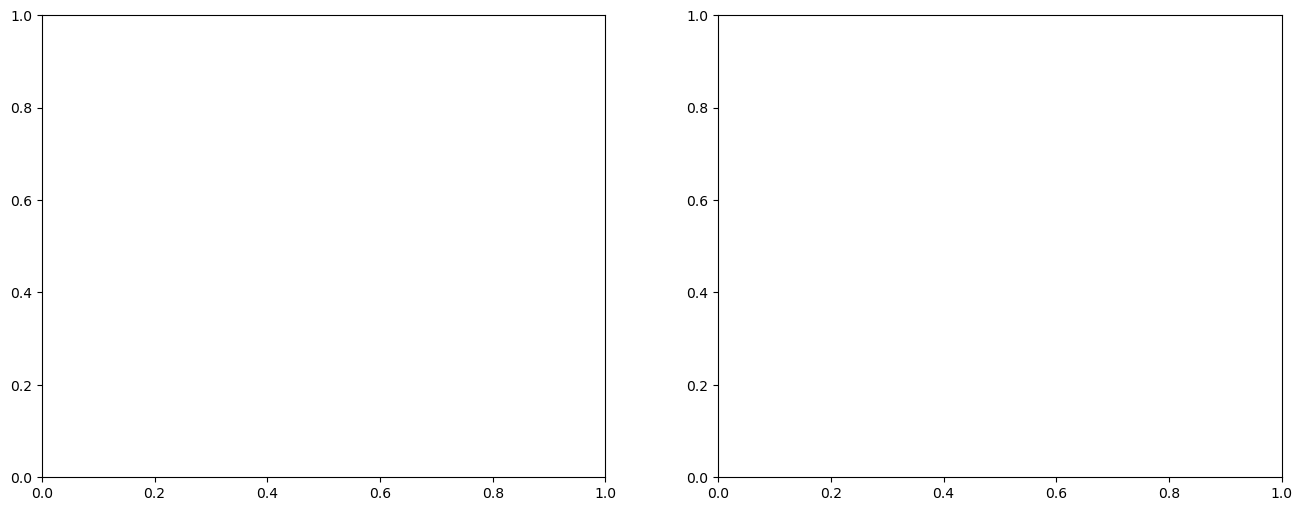

In [21]:
if STATS_LOADED:
    # Apply normalization
    transform = NormalizeWithPrecomputedStats.from_stats_file(model_name)
    normalized_data = transform(data)
    
    # Visualize raw vs normalized
    channel_name = 'sst_t2'  # Change this
    channel_idx = channel_info['channel_names'].index(channel_name)
    
    visualize_raw_vs_normalized(
        data, 
        normalized_data, 
        channel_idx, 
        channel_name
    )
    plt.suptitle(f"Year {metadata['year']}", fontsize=14, y=0.995)
    plt.show()
else:
    print("Normalization stats not loaded. Cannot visualize normalized data.")

### Example: Find Grid Point with Highest Normalized SST Value

In [ ]:
if STATS_LOADED:
    # Find the grid point with the highest normalized SST value
    channel_name = 'sst_t2'
    channel_idx = channel_info['channel_names'].index(channel_name)
    
    # Get the normalized SST data
    normalized_sst = normalized_data[channel_idx].numpy()
    
    # Find the maximum value and its location (ignoring NaN values)
    valid_mask = ~np.isnan(normalized_sst)
    max_value = np.nanmax(normalized_sst)
    max_idx = np.nanargmax(normalized_sst)
    max_lat, max_lon = np.unravel_index(max_idx, normalized_sst.shape)
    
    # Get the raw SST value at this location
    raw_sst = data[channel_idx, max_lat, max_lon].item()
    
    # Get the normalization statistics at this location
    mean_at_location = stats.mean[channel_idx, max_lat, max_lon].item()
    std_at_location = stats.std[channel_idx, max_lat, max_lon].item()
    
    print("="*80)
    print("GRID POINT WITH HIGHEST NORMALIZED SST VALUE")
    print("="*80)
    print(f"\nYear: {metadata['year']}")
    print(f"\nNormalized SST (max): {max_value:.4f} standard deviations")
    print(f"\nGrid point location:")
    print(f"  Latitude index:  {max_lat}")
    print(f"  Longitude index: {max_lon}")
    print(f"\nValues at this grid point:")
    print(f"  Raw SST value:        {raw_sst:.4f} K")
    print(f"  Mean (training):      {mean_at_location:.4f} K")
    print(f"  Std (training):       {std_at_location:.4f} K")
    print(f"  Normalized value:     {max_value:.4f} std")
    print(f"\nVerification:")
    print(f"  (raw - mean) / std = ({raw_sst:.4f} - {mean_at_location:.4f}) / {std_at_location:.4f}")
    print(f"                     = {(raw_sst - mean_at_location) / std_at_location:.4f}")
    print("="*80)
    
    # Visualize the normalized SST with the max point marked
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(normalized_sst, cmap='RdBu_r', vmin=-3, vmax=3, aspect='auto')
    ax.plot(max_lon, max_lat, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=1.5, 
            label=f'Max: {max_value:.2f} std at ({max_lat}, {max_lon})')
    ax.set_title(f'Normalized SST - Year {metadata["year"]} (Max point marked with green star)')
    ax.set_xlabel('Longitude index')
    ax.set_ylabel('Latitude index')
    ax.legend(loc='upper right')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Standard deviations')
    plt.tight_layout()
    plt.show()
    
else:
    print("Normalization stats not loaded. Cannot compute normalized SST.")

### Example: Visualize Normalization Statistics (Mean and Std Fields)

In [ ]:
if STATS_LOADED:
    channel_name = 'sst_t2'  # Change this
    channel_idx = stats.channel_names.index(channel_name)
    
    visualize_normalization_stats(stats, channel_idx, channel_name)
    plt.show()
else:
    print("Normalization stats not loaded.")

### Example: Examine Distribution of Values

In [ ]:
# Histogram of raw values for a channel
channel_name = 'sst_t2'  # Change this
channel_idx = channel_info['channel_names'].index(channel_name)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Raw data histogram
values = data[channel_idx].flatten().numpy()
axes[0].hist(values[~np.isnan(values)], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Raw Values Distribution: {channel_name}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

if STATS_LOADED:
    # Normalized data histogram
    normalized_values = normalized_data[channel_idx].flatten().numpy()
    axes[1].hist(normalized_values[~np.isnan(normalized_values)], bins=100, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'Normalized Values Distribution: {channel_name}')
    axes[1].set_xlabel('Value (standard deviations)')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(0, color='red', linestyle='--', label='Mean')
    axes[1].axvline(-1, color='orange', linestyle='--', alpha=0.5, label='±1 std')
    axes[1].axvline(1, color='orange', linestyle='--', alpha=0.5)
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Normalization stats not loaded', 
                ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

### Example: Load and Visualize Multiple Years

In [ ]:
# Compare a specific channel across multiple years
channel_name = 'sst_t2'  # Change this
channel_idx = channel_info['channel_names'].index(channel_name)

# Select up to 4 years to visualize
years_to_plot = available_years[:4]  # First 4 years

fig, axes = plt.subplots(1, len(years_to_plot), figsize=(16, 4))
if len(years_to_plot) == 1:
    axes = [axes]

for i, year in enumerate(years_to_plot):
    # Find sample for this year
    for idx in range(len(dataset)):
        if dataset.get_metadata(idx)['year'] == year:
            sample_data, _ = dataset[idx]
            break
    
    im = axes[i].imshow(sample_data[channel_idx], cmap='RdBu_r', aspect='auto')
    axes[i].set_title(f'Year {year}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle(f'Channel: {channel_name}', fontsize=14)
plt.tight_layout()
plt.show()